Phase 1 — Environment Setup & Pre-EDA

In [1]:
# 1.1: Install & Import Libraries
# Install if needed
!pip install pandas numpy matplotlib seaborn nltk scikit-learn wordcloud

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 300)

# 1.2: Load CSV Files
# Base dataset path
DATA_PATH = '/kaggle/input/datasets/arshkon/linkedin-job-postings/'

# Load key tables
postings = pd.read_csv(DATA_PATH + 'postings.csv')
companies = pd.read_csv(DATA_PATH + 'companies/companies.csv')
employee_counts = pd.read_csv(DATA_PATH + 'companies/employee_counts.csv')
job_skills = pd.read_csv(DATA_PATH + 'jobs/job_skills.csv')
benefits = pd.read_csv(DATA_PATH + 'jobs/benefits.csv')
job_industries = pd.read_csv(DATA_PATH + 'jobs/job_industries.csv')

# Show shapes
print("Postings shape:", postings.shape)
print("Companies shape:", companies.shape)
print("Employee counts shape:", employee_counts.shape)
print("Job Skills shape:", job_skills.shape)
print("Benefits shape:", benefits.shape)
print("Job industries shape:", job_industries.shape)

# Phase 1 Output Inspection (Initial Look)

# Inspect first few rows of postings
postings.head()

# Check summary of numeric columns
postings.describe()

# Check for missing values
missing_summary = postings.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_summary)

Postings shape: (123849, 31)
Companies shape: (24473, 10)
Employee counts shape: (35787, 4)
Job Skills shape: (213768, 2)
Benefits shape: (67943, 3)
Job industries shape: (164808, 2)
Missing values per column:
 closed_time                   122776
skills_desc                   121410
med_salary                    117569
remote_allowed                108603
applies                       100529
min_salary                     94056
max_salary                     94056
currency                       87776
compensation_type              87776
pay_period                     87776
normalized_salary              87776
posting_domain                 39968
application_url                36665
formatted_experience_level     29409
fips                           27415
zip_code                       20872
company_name                    1719
company_id                      1717
views                           1689
description                        7
job_id                             0
title       

Phase 2 EDA — Top Skills Bar Chart (Structured & Reproducible)

In [3]:
# Inspect the job_skills table structure
print("job_skills columns:", job_skills.columns.tolist())

# Show first few rows to understand the structure
job_skills.head()

job_skills columns: ['job_id', 'skill_abr']


,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


skills_mapping columns: ['skill_abr', 'skill_name']
Top 20 skills (with full names):
 skill_name
Information Technology    26137
Sales                     22475
Management                20861
Manufacturing             18185
Health Care Provider      17369
Business Development      14290
Engineering               13009
Other                     12608
Finance                    8540
Marketing                  5525
Accounting/Auditing        5461
Administrative             4860
Customer Service           4292
Project Management         3997
Analyst                    3858
Research                   2986
Human Resources            2647
Legal                      2371
Consulting                 2338
Education                  2290
Name: count, dtype: int64


/tmp/ipykernel_55/1356862609.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_skills.values, y=top_skills.index, palette='viridis')


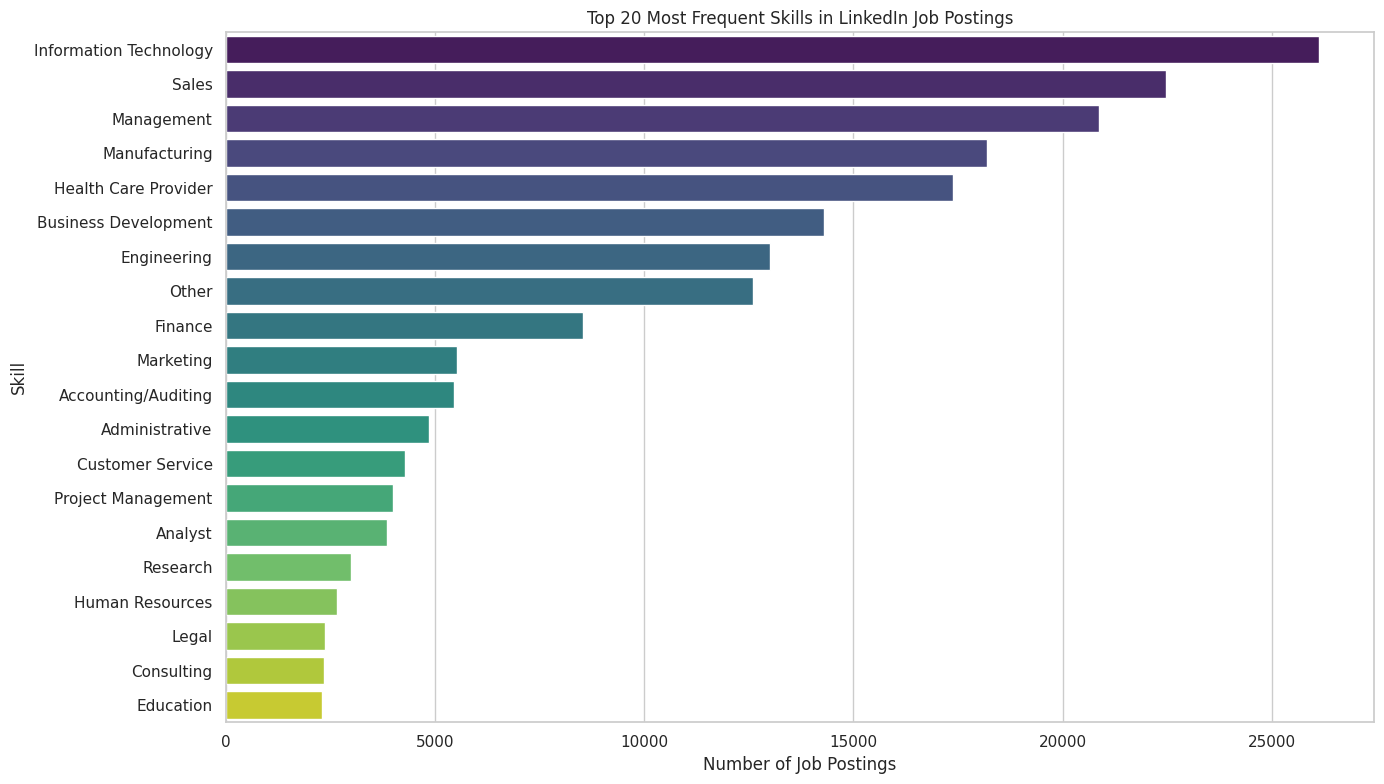

In [4]:
# Load the skill abbreviation mapping file
skills_mapping = pd.read_csv(DATA_PATH + 'mappings/skills.csv')

# Inspect the mapping file structure
print("skills_mapping columns:", skills_mapping.columns.tolist())
skills_mapping.head()

# Merge job_skills with full skill names
job_skills_named = job_skills.merge(skills_mapping, on='skill_abr', how='left')

# Check result
job_skills_named.head()

# Count frequency of full skill names
skill_counts = job_skills_named['skill_name'].value_counts()

# Inspect top 20 skills
top_skills = skill_counts.head(20)
print("Top 20 skills (with full names):\n", top_skills)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
sns.barplot(x=top_skills.values, y=top_skills.index, palette='viridis')

plt.title("Top 20 Most Frequent Skills in LinkedIn Job Postings")
plt.xlabel("Number of Job Postings")
plt.ylabel("Skill")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

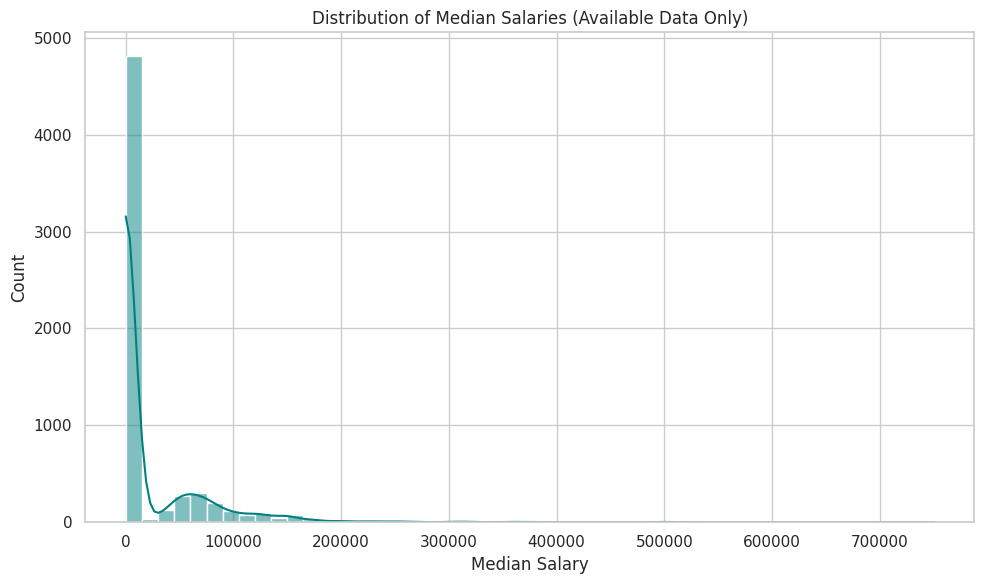

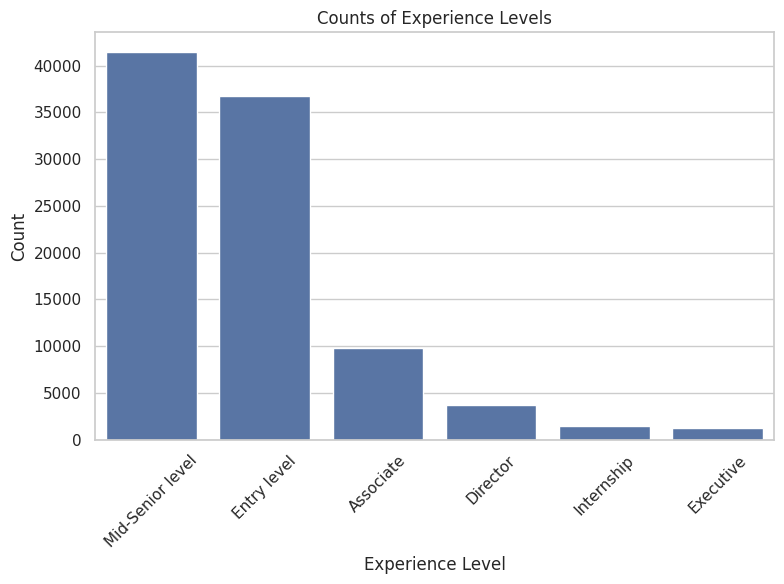

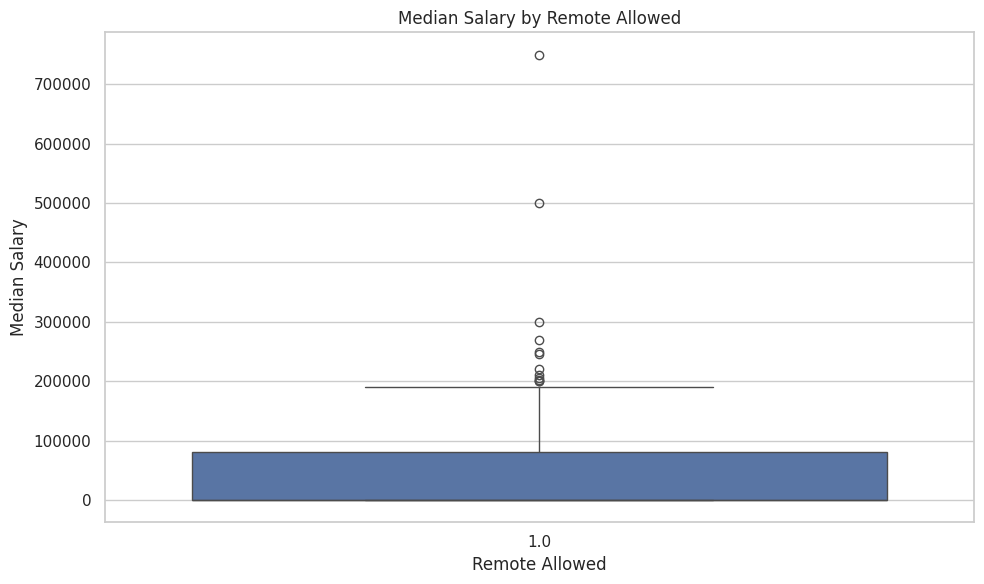

In [5]:
# Inspect the salary fields specifically
salary_cols = ['min_salary', 'med_salary', 'max_salary']
postings[salary_cols].describe()

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Filter out rows with no median salary
has_salary = postings[~postings['med_salary'].isnull()]

plt.figure(figsize=(10, 6))
sns.histplot(has_salary['med_salary'], bins=50, kde=True, color='teal')

plt.title('Distribution of Median Salaries (Available Data Only)')
plt.xlabel('Median Salary')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=postings, x='formatted_experience_level', order=postings['formatted_experience_level'].value_counts().index)

plt.title('Counts of Experience Levels')
plt.xlabel('Experience Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Filter to entries with salary for comparison
sal_remote = has_salary[['med_salary', 'remote_allowed']].dropna()

plt.figure(figsize=(10, 6))
sns.boxplot(data=sal_remote, x='remote_allowed', y='med_salary')

plt.title('Median Salary by Remote Allowed')
plt.xlabel('Remote Allowed')
plt.ylabel('Median Salary')
plt.tight_layout()
plt.show()

Phase 3 — Extract AI‑Related Signals from Job Text

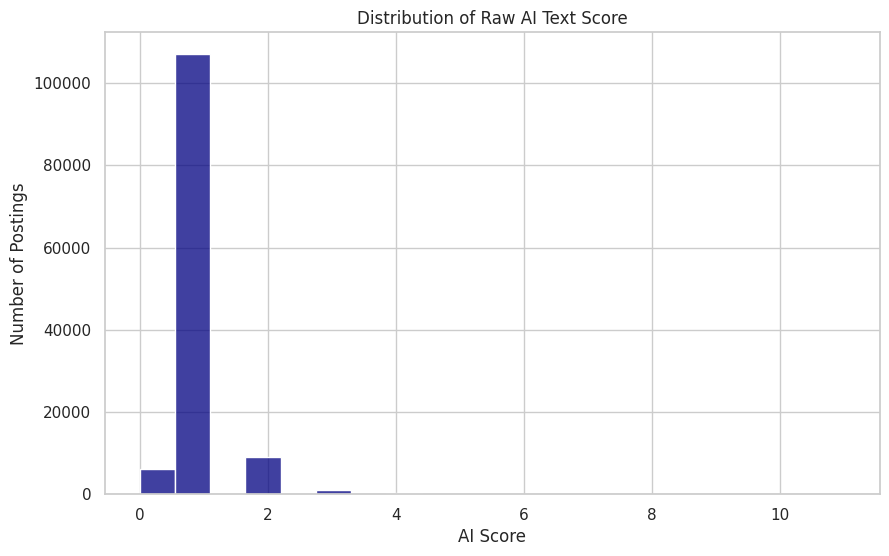

In [6]:
# Phase 3: AI Keyword list

ai_keywords = [
    'ai', 'machine learning', 'deep learning', 'neural network', 'nlp',
    'natural language', 'computer vision', 'tensorflow', 'pytorch',
    'python', 'data science', 'llm', 'gpt'
]

# Combine title + description for analysis
postings['text_combined'] = (postings['title'].fillna('') + ' ' 
                             + postings['description'].fillna(''))

# convert to lowercase for consistent matching
postings['text_lower'] = postings['text_combined'].str.lower()

for kw in ai_keywords:
    postings[f'ai_{kw.replace(" ", "_")}'] = postings['text_lower'].str.contains(kw)

# Preview
postings[['text_lower'] + [f'ai_{kw.replace(" ", "_")}' for kw in ai_keywords]].head()

ai_cols = [col for col in postings.columns if col.startswith('ai_')]
postings['ai_score_raw'] = postings[ai_cols].sum(axis=1)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(postings['ai_score_raw'], bins=20, kde=False, color='navy')
plt.title("Distribution of Raw AI Text Score")
plt.xlabel("AI Score")
plt.ylabel("Number of Postings")
plt.show()

has_ai_signal
True     117790
False      6059
Name: count, dtype: int64


/tmp/ipykernel_55/1789544299.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ai_count.index.astype(str), y=ai_count.values, palette='coolwarm')


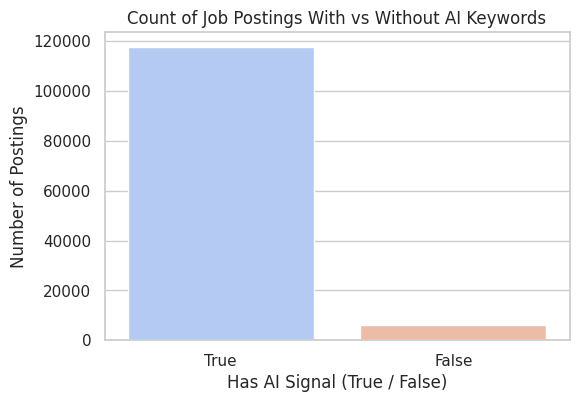

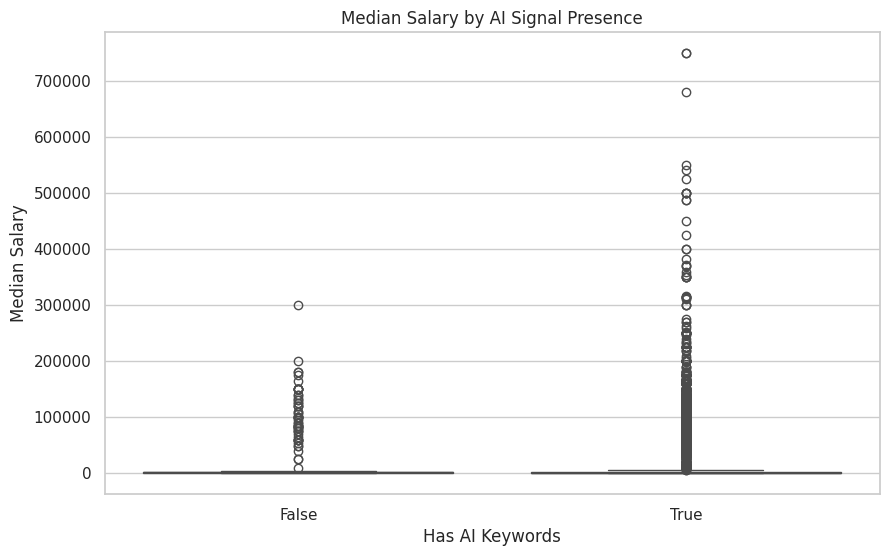

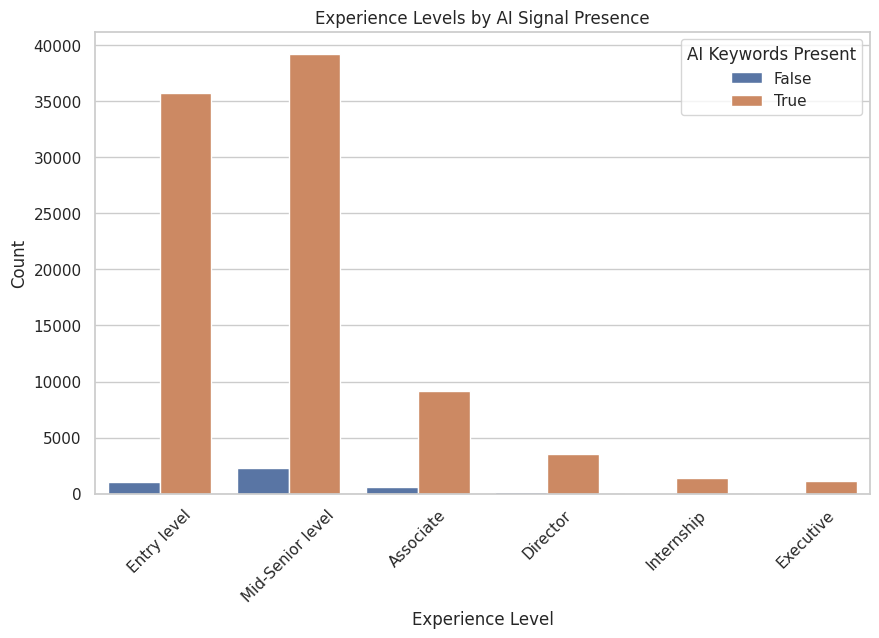

In [7]:
# Flag postings with any AI signal
postings['has_ai_signal'] = (postings['ai_score_raw'] > 0)

# Count of postings with vs without AI signals
ai_count = postings['has_ai_signal'].value_counts()
print(ai_count)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=ai_count.index.astype(str), y=ai_count.values, palette='coolwarm')
plt.title("Count of Job Postings With vs Without AI Keywords")
plt.xlabel("Has AI Signal (True / False)")
plt.ylabel("Number of Postings")
plt.show()

# Filter to postings with salary and AI flag
salary_ai = postings[~postings['med_salary'].isnull()][['med_salary', 'has_ai_signal']]

plt.figure(figsize=(10,6))
sns.boxplot(data=salary_ai, x='has_ai_signal', y='med_salary')
plt.title("Median Salary by AI Signal Presence")
plt.xlabel("Has AI Keywords")
plt.ylabel("Median Salary")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=postings, x='formatted_experience_level', hue='has_ai_signal')
plt.title("Experience Levels by AI Signal Presence")
plt.xlabel("Experience Level")
plt.ylabel("Count")
plt.legend(title="AI Keywords Present")
plt.xticks(rotation=45)
plt.show()

Phase 4 — Refined AI Score Using Embeddings

In [8]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 13.2 MB/s eta 0:00:0000:01
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.2.0
    Uninstalling sentence-transformers-5.2.0:
      Successfully uninstalled sentence-transformers-5.2.0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3871 [00:00<?, ?it/s]

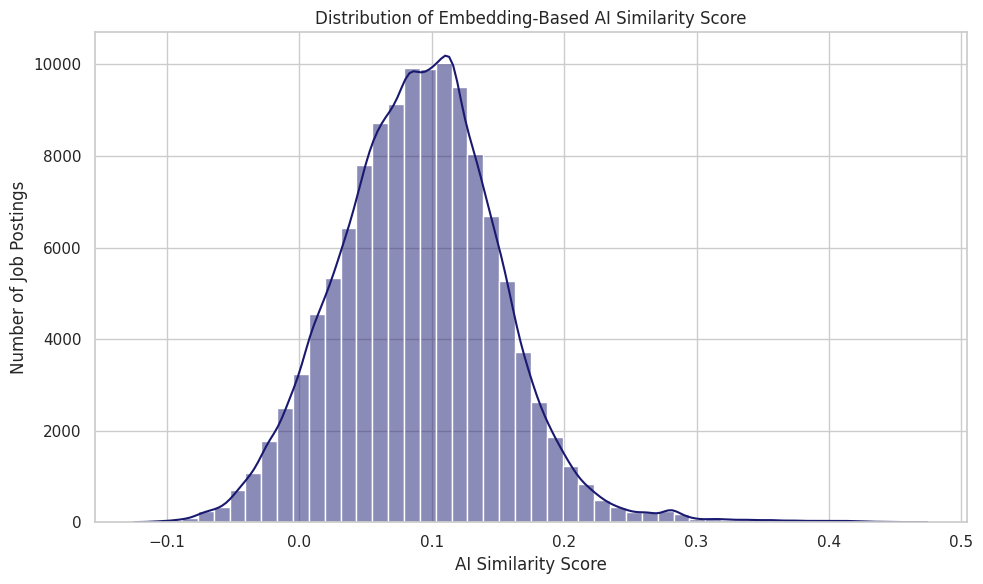

In [9]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a compact sentence embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Define AI related anchor phrases
ai_anchor_phrases = [
    "artificial intelligence",
    "machine learning",
    "deep learning",
    "neural networks",
    "natural language processing",
    "computer vision",
    "large language models",
    "AI ethics",
    "transformer models",
    "reinforcement learning"
]

# Get embeddings for anchors
ai_anchor_embeddings = model.encode(ai_anchor_phrases)

# Compute average anchor vector
ai_anchor_vector = np.mean(ai_anchor_embeddings, axis=0)

# Sample texts for embedding
texts = postings['text_combined'].fillna('').tolist()

# Encode all job postings
job_embeddings = model.encode(texts, show_progress_bar=True)

from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
similarities = cosine_similarity(job_embeddings, ai_anchor_vector.reshape(1, -1))

# Flatten to a vector
postings['ai_score_embed'] = similarities.flatten()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(postings['ai_score_embed'], bins=50, kde=True, color='midnightblue')

plt.title("Distribution of Embedding‑Based AI Similarity Score")
plt.xlabel("AI Similarity Score")
plt.ylabel("Number of Job Postings")
plt.tight_layout()
plt.show()

In [10]:
postings[['ai_score_raw', 'ai_score_embed']].corr()
# Top 10 postings with highest AI score
postings.sort_values('ai_score_embed', ascending=False).head(10)[['title','location','ai_score_embed']]

,title,location,ai_score_embed
64259,Machine Learning Team Lead,"Tulsa, OK",0.474191
75752,Artificial Intelligence / Machine Learning Research and Development Engineer,"Reston, VA",0.471607
75455,Artificial Intelligence / Machine Learning Research and Development Engineer,"University Park, PA",0.471607
333,Artificial Intelligence Engineer Intern - Chatbot,United States,0.461282
121293,"Senior Software Engineer, Machine Learning","New York, NY",0.457038
7655,AI/ML Engineer (Contract) (Hybrid) – 4313,"Irvine, CA",0.451918
121841,Machine Learning Engineer I,Greater Cleveland,0.450797
109826,"Intern, Machine Learning","San Francisco, CA",0.450789
60469,Machine Learning Engineer,"Austin, TX",0.449666
115412,Senior NLP Research Engineer - Artificial Intelligence Group,"New York, NY",0.446478


Phase 5 — Regression Modeling

In [32]:
import numpy as np
import pandas as pd

# Make a fresh copy for modeling
reg_data = postings.copy()

# Keep rows with median salary
reg_data = reg_data[~reg_data['med_salary'].isna()]

# Log transform median salary
reg_data['log_med_salary'] = np.log1p(reg_data['med_salary'])

# Categorical controls
reg_data['experience_level'] = reg_data['formatted_experience_level'].fillna('Unknown')
reg_data['work_type'] = reg_data['formatted_work_type'].fillna('Unknown')

# Drop rows with missing essential scores
reg_data = reg_data[~reg_data['ai_score_embed'].isna()]

print("Regression dataset shape:", reg_data.shape)

Regression dataset shape: (6280, 52)


In [39]:
# Create dummies for categorical variables
reg_data = pd.get_dummies(
    reg_data,
    columns=['experience_level', 'work_type'],
    drop_first=True
)

# Remote as numeric
reg_data['remote_flag'] = reg_data['remote_allowed'].fillna(False).astype(int)

print("Columns after dummies:", reg_data.columns[:10])

Columns after dummies: Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary'],
      dtype='object')


In [40]:
# Ensure all predictors are numeric

# List of predictors you want
numeric_cols = ['ai_score_embed', 'remote_flag']
dummy_cols = [c for c in reg_data.columns if c.startswith('experience_level_') or c.startswith('work_type_')]

predictor_cols = numeric_cols + dummy_cols

# Convert all predictor columns to numeric (forcing errors to NaN)
for col in predictor_cols:
    reg_data[col] = pd.to_numeric(reg_data[col], errors='coerce')

# Now check dtypes
print(reg_data[predictor_cols].dtypes)

ai_score_embed                       float32
remote_flag                            int64
experience_level_Director               bool
experience_level_Entry level            bool
experience_level_Executive              bool
experience_level_Internship             bool
experience_level_Mid-Senior level       bool
experience_level_Unknown                bool
work_type_Full-time                     bool
work_type_Internship                    bool
work_type_Other                         bool
work_type_Part-time                     bool
work_type_Temporary                     bool
work_type_Volunteer                     bool
dtype: object


In [41]:
# Convert bool dummies to int
for col in reg_data.columns:
    if reg_data[col].dtype == 'bool':
        reg_data[col] = reg_data[col].astype(int)

# Check again
print(reg_data[dummy_cols].dtypes)

experience_level_Director            int64
experience_level_Entry level         int64
experience_level_Executive           int64
experience_level_Internship          int64
experience_level_Mid-Senior level    int64
experience_level_Unknown             int64
work_type_Full-time                  int64
work_type_Internship                 int64
work_type_Other                      int64
work_type_Part-time                  int64
work_type_Temporary                  int64
work_type_Volunteer                  int64
dtype: object


In [42]:
# Convert bool dummies to int
for col in reg_data.columns:
    if reg_data[col].dtype == 'bool':
        reg_data[col] = reg_data[col].astype(int)

# Prepare predictors again
numeric_cols = ['ai_score_embed', 'remote_flag']
dummy_cols = [c for c in reg_data.columns if
              c.startswith('experience_level_') or c.startswith('work_type_')]

predictor_cols = numeric_cols + dummy_cols

# Ensure numeric types
for col in predictor_cols:
    reg_data[col] = pd.to_numeric(reg_data[col], errors='coerce')

# Drop any rows with missing values
reg_data_clean = reg_data.dropna(subset=predictor_cols + ['log_med_salary'])

# Define y and X
y = reg_data_clean['log_med_salary']
X = reg_data_clean[predictor_cols]

# Add intercept
X = sm.add_constant(X)

# Fit model with robust errors
model = sm.OLS(y, X).fit(cov_type='HC3')

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_med_salary   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     119.9
Date:                Mon, 23 Feb 2026   Prob (F-statistic):          1.12e-309
Time:                        14:31:27   Log-Likelihood:                -16114.
No. Observations:                6280   AIC:                         3.226e+04
Df Residuals:                    6265   BIC:                         3.236e+04
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [51]:
# Rename columns in reg_data_clean
reg_data_clean = reg_data_clean.rename(
    columns=lambda x: x.replace(" ", "_")
                  .replace("-", "_")
                  .replace("/", "_")
                  .replace(".", "_")
)

# Check problematic names are fixed
print("Clean predictor columns:")
print([c for c in reg_data_clean.columns if " " in c or "-" in c or "/" in c])

Clean predictor columns:
[]


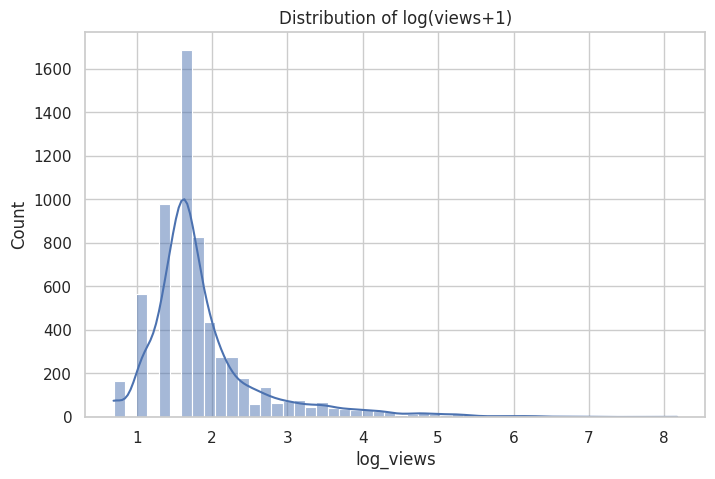

count    6233.000000
mean        1.880968
std         0.798605
min         0.693147
25%         1.386294
50%         1.609438
75%         2.079442
max         8.171599
Name: log_views, dtype: float64


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(reg_data_clean['log_views'], bins=50, kde=True)
plt.title('Distribution of log(views+1)')
plt.xlabel('log_views')
plt.ylabel('Count')
plt.show()

print(reg_data_clean['log_views'].describe())

In [54]:
import statsmodels.formula.api as smf

# Rebuild predictors now that column names are cleaned
predictors = ['ai_score_embed', 'remote_flag'] + \
             [col for col in reg_data_clean.columns if
              col.startswith('experience_level_') or col.startswith('work_type_')]

# Build the Patsy formula string
formula = "log_views ~ " + " + ".join(predictors)

# Fit the median regression (0.5 quantile)
median_model = smf.quantreg(formula, data=reg_data_clean).fit(q=0.5)

# Print the summary
print(median_model.summary())

                         QuantReg Regression Results                          
Dep. Variable:              log_views   Pseudo R-squared:              0.03184
Model:                       QuantReg   Bandwidth:                      0.1109
Method:                 Least Squares   Sparsity:                       0.5926
Date:                Mon, 23 Feb 2026   No. Observations:                 6233
Time:                        14:37:45   Df Residuals:                     6218
                                        Df Model:                           14
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.1282      0.019    112.969      0.000       2.091       2.165
ai_score_embed                     5.921e-06      0.068   8.74e-05      1.000      -0.133       0.133
remote_flag                           0

                              feature        VIF
0                               const  24.864544
1                      ai_score_embed   1.051105
2                         remote_flag   1.047399
3           experience_level_Director   1.153941
4        experience_level_Entry level   4.385540
5          experience_level_Executive   1.060990
6         experience_level_Internship   1.600440
7   experience_level_Mid-Senior level   3.469453
8            experience_level_Unknown   3.484226
9                 work_type_Full-time   2.393180
10               work_type_Internship   1.461795
11                    work_type_Other   1.080257
12                work_type_Part-time   2.182577
13                work_type_Temporary   1.176799
14                work_type_Volunteer   1.017651


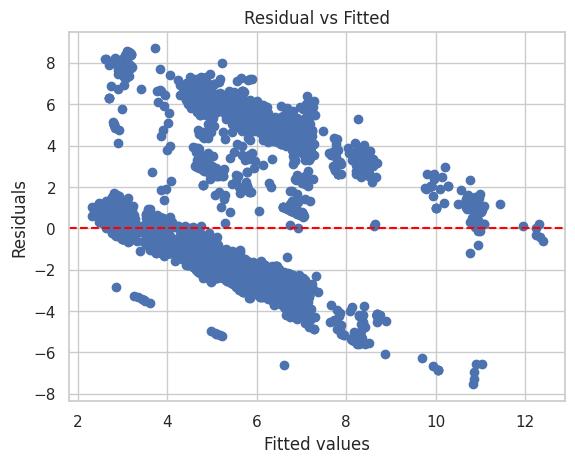

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF_df = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(VIF_df)

import matplotlib.pyplot as plt

plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual vs Fitted")
plt.show()

In [56]:
# 1. Interaction Effects (AI × Remote)
reg_data_clean['ai_x_remote'] = reg_data_clean['ai_score_embed'] * reg_data_clean['remote_flag']

X2 = reg_data_clean[['ai_score_embed', 'remote_flag', 'ai_x_remote'] + 
                    [c for c in reg_data_clean.columns if 'experience_level_' in c or 'work_type_' in c]]

X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit(cov_type='HC3')

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         log_med_salary   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     112.3
Date:                Mon, 23 Feb 2026   Prob (F-statistic):          1.31e-309
Time:                        14:37:52   Log-Likelihood:                -16113.
No. Observations:                6280   AIC:                         3.226e+04
Df Residuals:                    6264   BIC:                         3.237e+04
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [57]:
# 2. Alternative Specifications

reg_data_clean['log_ai_score'] = np.log1p(reg_data_clean['ai_score_embed'])

In [58]:
# 3. Heterogeneity Analysis

senior = reg_data_clean[reg_data_clean['experience_level_Mid_Senior_level'] == 1]

In [59]:
# Convert listed_time to datetime
reg_data_clean['listed_time'] = pd.to_datetime(reg_data_clean['listed_time'], errors='coerce')

# Now extract year
reg_data_clean['year'] = reg_data_clean['listed_time'].dt.year

# Check basic distribution
print(reg_data_clean['year'].value_counts().sort_index())

year
1970    6280
Name: count, dtype: int64


In [60]:
print(postings['listed_time'].head(20))
print(postings['listed_time'].dtype)

0     1.713398e+12
1     1.712858e+12
2     1.713278e+12
3     1.712896e+12
4     1.713452e+12
5     1.713456e+12
6     1.712861e+12
7     1.712443e+12
8     1.712348e+12
9     1.712456e+12
10    1.713211e+12
11    1.712858e+12
12    1.712870e+12
13    1.712461e+12
14    1.713537e+12
15    1.713466e+12
16    1.712856e+12
17    1.713532e+12
18    1.713457e+12
19    1.713210e+12
Name: listed_time, dtype: float64
float64


In [63]:
# Properly convert listed_time from milliseconds to datetime
postings['listed_time_dt'] = pd.to_datetime(postings['listed_time'], unit='ms', origin='unix', errors='coerce')

# Check first few values
print(postings['listed_time_dt'].head())
print(postings['listed_time_dt'].dtype)

0   2024-04-17 23:45:08
1   2024-04-11 17:51:27
2   2024-04-16 14:26:54
3   2024-04-12 04:23:32
4   2024-04-18 14:52:23
Name: listed_time_dt, dtype: datetime64[ns]
datetime64[ns]


In [64]:
# Map the correct datetime back into reg_data_clean
reg_data_clean = reg_data_clean.copy()

# Join the postings table’s datetime back into reg_data_clean
reg_data_clean = reg_data_clean.merge(
    postings[['job_id', 'listed_time_dt']],
    on='job_id',
    how='left'
)

# Now extract year from the correct datetime
reg_data_clean['year'] = reg_data_clean['listed_time_dt'].dt.year

# Check distribution
print(reg_data_clean['year'].value_counts().sort_index())

year
2024    6280
Name: count, dtype: int64


In [65]:
# Extract month and quarter from correct datetime
reg_data_clean['month'] = reg_data_clean['listed_time_dt'].dt.month
reg_data_clean['quarter'] = reg_data_clean['listed_time_dt'].dt.quarter

print("Months present:", sorted(reg_data_clean['month'].unique()))
print("Quarters present:", sorted(reg_data_clean['quarter'].unique()))

Months present: [np.int32(3), np.int32(4)]
Quarters present: [np.int32(1), np.int32(2)]


In [66]:
import statsmodels.api as sm

# 1) Create month dummies
month_dummies = pd.get_dummies(reg_data_clean['month'], prefix='month', drop_first=True)

# 2) Combine with the regression dataset
reg_data_time = pd.concat([reg_data_clean, month_dummies], axis=1)

# 3) Build the predictor list
predictors_time = ['ai_score_embed', 'remote_flag'] + \
    [c for c in reg_data_time.columns if 
     c.startswith('experience_level_') or c.startswith('work_type_') or c.startswith('month_')]

# 4) Ensure all predictors are numeric
for col in predictors_time:
    # Convert booleans -> int, and force numeric
    reg_data_time[col] = pd.to_numeric(reg_data_time[col].astype(int), errors='coerce')

# 5) Construct X and y
X_time = reg_data_time[predictors_time]
X_time = sm.add_constant(X_time)  # add intercept

y_time = reg_data_time['log_med_salary']

# 6) Drop any rows with non‑numeric issues
final_data = pd.concat([X_time, y_time], axis=1).dropna()

X_time_clean = final_data[X_time.columns]
y_time_clean = final_data['log_med_salary']

# 7) Fit OLS with robust errors
model_time = sm.OLS(y_time_clean, X_time_clean).fit(cov_type='HC3')

print(model_time.summary())

                            OLS Regression Results                            
Dep. Variable:         log_med_salary   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     119.0
Date:                Mon, 23 Feb 2026   Prob (F-statistic):          2.28e-307
Time:                        14:38:26   Log-Likelihood:                -16121.
No. Observations:                6280   AIC:                         3.227e+04
Df Residuals:                    6265   BIC:                         3.237e+04
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


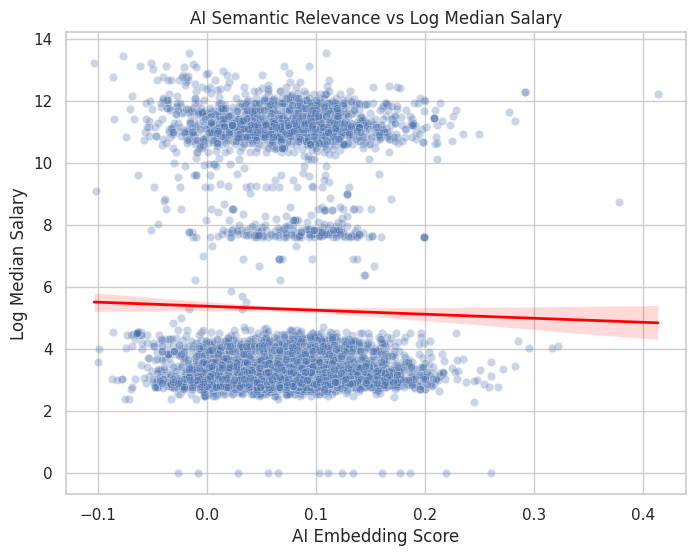

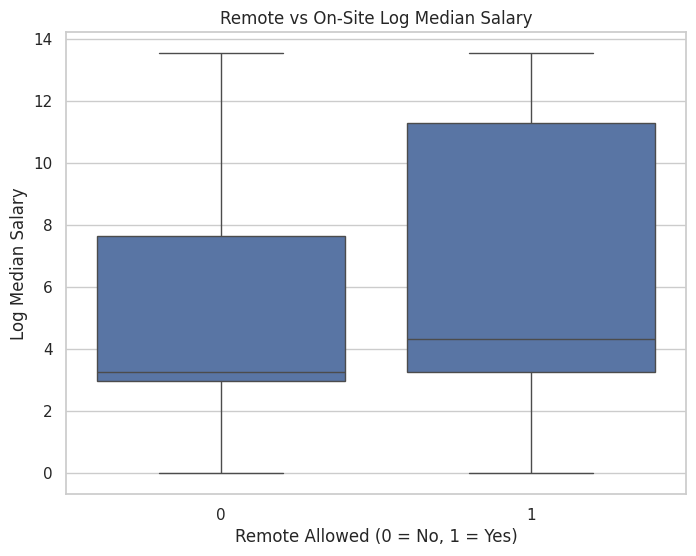

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# AI vs Salary scatter with trendline
plt.figure(figsize=(8,6))
sns.scatterplot(x='ai_score_embed', y='log_med_salary', data=reg_data_clean, alpha=0.3)
sns.regplot(x='ai_score_embed', y='log_med_salary', data=reg_data_clean,
            scatter=False, color='red', line_kws={'linewidth':2})
plt.title("AI Semantic Relevance vs Log Median Salary")
plt.xlabel("AI Embedding Score")
plt.ylabel("Log Median Salary")
plt.show()

# Remote vs Salary boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='remote_flag', y='log_med_salary', data=reg_data_clean)
plt.title("Remote vs On‑Site Log Median Salary")
plt.xlabel("Remote Allowed (0 = No, 1 = Yes)")
plt.ylabel("Log Median Salary")
plt.show()

In [68]:
senior = reg_data_clean[reg_data_clean['experience_level_Mid_Senior_level'] == 1]
X_senior = senior[['ai_score_embed', 'remote_flag'] + 
                   [c for c in senior.columns if c.startswith('work_type_')]]
X_senior = sm.add_constant(X_senior)
y_senior = senior['log_med_salary']

model_senior = sm.OLS(y_senior, X_senior).fit(cov_type='HC3')
print(model_senior.summary())

                            OLS Regression Results                            
Dep. Variable:         log_med_salary   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     56.56
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           8.77e-72
Time:                        14:38:35   Log-Likelihood:                -3919.5
No. Observations:                1459   AIC:                             7855.
Df Residuals:                    1451   BIC:                             7897.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.8366 

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


In [69]:
y = reg_data_clean['log_med_salary']
X_kw = reg_data_clean[['ai_score_raw', 'remote_flag'] + 
                       [c for c in reg_data_clean.columns if c.startswith('experience_level_') 
                        or c.startswith('work_type_')]]
X_kw = sm.add_constant(X_kw)
model_kw = sm.OLS(y, X_kw).fit(cov_type='HC3')
print(model_kw.summary())

                            OLS Regression Results                            
Dep. Variable:         log_med_salary   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     119.1
Date:                Mon, 23 Feb 2026   Prob (F-statistic):          1.21e-307
Time:                        14:38:38   Log-Likelihood:                -16121.
No. Observations:                6280   AIC:                         3.227e+04
Df Residuals:                    6265   BIC:                         3.237e+04
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [70]:
import statsmodels.api as sm

# 1) Drop missing or invalid views
views_data = reg_data_clean.copy()
views_data = views_data[views_data['views'].notna()]  # keep only rows where views is not NaN

# 2) Convert views to int safely
views_data['views_int'] = views_data['views'].astype(int)

# 3) Build predictor matrix
X_views_nb = views_data[['ai_score_embed', 'remote_flag'] + 
                         [c for c in views_data.columns if
                          c.startswith('experience_level_') or c.startswith('work_type_')]]

# 4) Convert predictors to numeric
for col in X_views_nb.columns:
    X_views_nb[col] = pd.to_numeric(X_views_nb[col].astype(int), errors='coerce')

X_views_nb = sm.add_constant(X_views_nb)

# 5) Define dependent variable as views_int
y_views_nb = views_data['views_int']

# 6) Fit Negative Binomial regression
nb_model = sm.GLM(y_views_nb, X_views_nb, family=sm.families.NegativeBinomial()).fit()

print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              views_int   No. Observations:                 6233
Model:                            GLM   Df Residuals:                     6219
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20305.
Date:                Mon, 23 Feb 2026   Deviance:                       5970.0
Time:                        14:38:41   Pearson chi2:                 5.68e+04
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4204
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

/tmp/ipykernel_55/3844042639.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_views_nb[col] = pd.to_numeric(X_views_nb[col].astype(int), errors='coerce')
/tmp/ipykernel_55/3844042639.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_views_nb[col] = pd.to_numeric(X_views_nb[col].astype(int), errors='coerce')
/tmp/ipykernel_55/3844042639.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the